In [ ]:
# Imports 


import sys
# setting path
sys.path.append('../core')
import os
#os.environ["VECLIB_MAXIMUM_THREADS"] = "10"

from sklearn.decomposition import PCA

#bread and butter
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#machine learning library
import sklearn
import sklearn.manifold
import sklearn.cluster
import sklearn.decomposition

#statistics
import scipy
from scipy.stats import rankdata, norm

import numba
from numba import jit, njit

from tqdm import tqdm
import copy
import cvxpy as cp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#import numpy as tnp
import warnings
warnings.filterwarnings('ignore')

# import dfply
# from dfply import *
# import ray
# import datetime


import os
import warnings
warnings.filterwarnings("ignore")

#import torch
#torch.cuda.is_available()
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import scipy

import confound_mdp
import confound_ope
import confound_env
import copy
import pickle

from subspace import *
from clustering import *
from emalg import *
from helpers import *

%matplotlib inline
plt.style.use('matplotlibrc')

Simplifications to Sepsis: (1) Rewards no longer dependent on diabetes or no diabetes (averaged across them), (2) Initial state distribution now common across diabetes/no diabetes (averaged across them).


In [3]:
def idx_to_trunc(state_idx, hideGlucose=True, sa=False):
    """idx_to_trunc

    The state index is determined by using "bit" arithmetic, with the
    complication that not every state is binary

    :param state_idx: Given index (720)
    
    Returns a truncated state where the "action states", 
    antibiotics, vasopressors and ventilators, are omitted
    """
    term_base = 720/3 #starts with heart rate

    # Start with the given state index
    mod_idx = state_idx

    hr_state = np.floor(mod_idx/term_base).astype(int)

    mod_idx %= term_base
    term_base /= 3
    sysbp_state = np.floor(mod_idx/term_base).astype(int)

    mod_idx %= term_base
    term_base /= 2
    percoxyg_state = np.floor(mod_idx/term_base).astype(int)

    mod_idx %= term_base
    term_base /= 5
    glucose_state = np.floor(mod_idx/term_base).astype(int)
    
    categ_num = np.array([3,3,2,5])
    state_categs = [
            hr_state,
            sysbp_state,
            percoxyg_state,
            glucose_state]
    if hideGlucose:
        mod_idx %= term_base
        term_base /= 2
        antibiotic_state = np.floor(mod_idx/term_base).astype(int)

        mod_idx %= term_base
        term_base /= 2
        vaso_state = np.floor(mod_idx/term_base).astype(int)

        mod_idx %= term_base
        term_base /= 2
        vent_state = np.floor(mod_idx/term_base).astype(int)
        categ_num = np.array([3,3,2,2,2,2])
        state_categs = [
                hr_state,
                sysbp_state,
                percoxyg_state,
                antibiotic_state,
                vaso_state,
                vent_state]
    sum_idx = 0
    prev_base = 1
    for i in range(len(state_categs)):
        idx = len(state_categs) - 1 - i
        sum_idx += prev_base*state_categs[idx]
        prev_base *= categ_num[idx]
        
    if sa:
        mod_idx %= term_base
        term_base /= 2
        antibiotic_state = np.floor(mod_idx/term_base).astype(int)

        mod_idx %= term_base
        term_base /= 2
        vaso_state = np.floor(mod_idx/term_base).astype(int)

        mod_idx %= term_base
        term_base /= 2
        vent_state = np.floor(mod_idx/term_base).astype(int)
        action = 4*antibiotic_state + 2*vaso_state + 2*vent_state
        return sum_idx, action
    else:
        return sum_idx

idx_to_trunc(719, sa=True)

(143, 0)

In [ ]:
diagnostic = False
horizons = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
#horizons = [180]

trials = 30
hideGlucose = True
import multiprocessing


clusterAccsTrials = []
clusterAccsNoProjsTrials = []
classAccsTrials = []
hardClustEMAccsTrials = []
softClustEMAccsTrials = []
hardEMAccsTrials = []
softEMAccsTrials = []

for trial in range(trials):
    clusterAccs = []
    clusterAccsNoProjs = []
    modelEstims = []
    classAccs = []
    hardClustEMs = []
    hardClustEMAccs = []
    softClustEMs = []
    softClustEMAccs = []
    hardEMs = []
    hardEMAccs = []
    softEMs = []
    softEMAccs = []
    
    start_seed = trial*multiprocessing.cpu_count()
    print("Trial", trial, "with start seed", start_seed)

    for horizon in horizons:
        print("Current Horizon is:", horizon)

        #########SETUP#########

        # Get the transition and reward matrix from file
        with open("./data/diab_txr_mats-replication.pkl", "rb") as f:
            mdict = pickle.load(f)

        envs = []

        P = mdict["tx_mat"]
        x_dist = mdict["p_initial_state"].mean(0)
        u_dist = mdict["p_mixture"]
        gamma = 1


        #nStates = P.shape[2]
        nActions = P.shape[1]

        R = mdict["r_mat"].mean(0)

        pi_b = np.load('data/sepsisPol.npy')
        pi_e = pi_b.mean(0)

        term = -1
        mdp = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)


        dataset = getSamplesMultiProc(500, mdp, pi_b, horizon, start_seed=start_seed, iid=False)



        for m in tqdm(range(dataset.shape[0])):
            for t in range(dataset.shape[1]):
                #s, a, u, s', r
                dataset[m,t,0] = idx_to_trunc(dataset[m,t,0], hideGlucose=hideGlucose)
                dataset[m,t,3] = idx_to_trunc(dataset[m,t,3], hideGlucose=hideGlucose)



         # behavior value
        print("value of pi_b")
        returns = confound_mdp.calc_returns(dataset, gamma, horizon)
        print(returns.mean())



        nStates = int(720/8) if not hideGlucose else int(720/(5))

        stateactions = dataset[:, :, [0, 1]]
        memorder = 'C'

        if memorder == 'F':
            stateactions = (dataset[:,:,0] + dataset[:,:,1]*nStates).astype(int) #we code (S x A) as s + a|S|, 0,16,32,48 1,17,33,49
        else:
            stateactions = (dataset[:,:,0]*nActions + dataset[:,:,1]).astype(int)
        states = (dataset[:,:,0]).astype(int)
        actions = (dataset[:,:,1]).astype(int)
        currstates = dataset[:,:,[0,1]].astype(int)
        confounders = dataset[:,:,2].astype(int)
        labels = confounders[:,0].astype(int)
        nextstates = dataset[:,:,3].astype(int)

        L = 2
        K = 2
        #S = nStates*nActions
        #N = len(threes)


        ########SUBSPACE ESTIMATION########

        sadim = nStates*nActions
        spdim = nStates
        omegaone = np.array([i for i in range(int(horizon/4), 2*int(horizon/4))])
        omegatwo = np.array([i for i in range(3*int(horizon/4), horizon)])
        onehotsa = np.eye(sadim)[stateactions]
        #onehotsaflat = copy.deepcopy(onehotsa)
        onehotsa = onehotsa.reshape((onehotsa.shape[0], onehotsa.shape[1], nStates, nActions), order=memorder)
        onehotsp = np.eye(np.max(nextstates)+1)[nextstates]
        sz = int(onehotsa.shape[0]/3)

        eigvalsa, eigvecsa = getEig(onehotsa[:sz], onehotsp[:sz], omegaone, omegatwo, K, wt=True, smalldata=False, device='/GPU:0')

        #########CLUSTERING#########

        device = "/GPU:0"

        hs = np.array([geth(onehotsa[sz:,omegaone,:,:], 
                                         onehotsp[sz:,omegaone,:]), 
                                  geth(onehotsa[sz:,omegatwo,:,:], 
                                       onehotsp[sz:,omegatwo,:])], dtype=np.float32)

        statmns = computeStat(hs, 
                          eigvecsa, numpy=False, smalldata=False, device=device, proj=True)
        
        statNoProjs = computeStat(hs, 
                          eigvecsa, numpy=False, smalldata=False, device=device, proj=False)
        if diagnostic:
            hi = 0.00005 if hideGlucose else 0.00012
            clusterDiagnostics(statmns, K=K, labels=confounders[sz:, 0],
                           lo=0, hi=hi, step=0.02*hi) #0,0.01, 0.0001
            plt.show()
            clusterDiagnostics(statNoProjs, K=K, labels=confounders[sz:, 0],
                       lo=0, hi=hi, step=0.02*hi) #0,0.01, 0.0001
            plt.show()


        thresh = 2e-5 if hideGlucose else 0.00003 #0.0005
        clusterlabs = sklearn.cluster.spectral_clustering((statmns < thresh).astype(int), n_clusters=2,
                                                         assign_labels='kmeans')

        clusterlabsNoProjs = sklearn.cluster.spectral_clustering((statNoProjs < thresh).astype(int), n_clusters=2,
                                                         assign_labels='kmeans')

        permutation = np.argmax([np.mean(clusterlabs == confounders[sz:, 0]), 
                        np.mean(clusterlabs != confounders[sz:, 0])])
        if diagnostic:
            print(permutation, np.max([np.mean(clusterlabs == confounders[sz:, 0]), 
                        np.mean(clusterlabs != confounders[sz:, 0])]))
        clusterAccs.append(np.max([np.mean(clusterlabs == confounders[sz:, 0]), 
                        np.mean(clusterlabs != confounders[sz:, 0])]))

        clusterAccsNoProjs.append(np.max([np.mean(clusterlabsNoProjs == confounders[sz:, 0]), 
                        np.mean(clusterlabsNoProjs != confounders[sz:, 0])]))

        ########MODEL ESTIMATION#########
        Phat_ksa = getModelEstim(clusterlabs.astype(int), 
                             states[sz:,:], 
                             actions[sz:,:], 
                             nextstates[sz:,:],
                            K=K, nStates=nStates, nActions=nActions, hard=True)
        modelEstims.append(Phat_ksa)


        ########CLASSIFICATION#########
        priorclass = np.bincount(clusterlabs)/len(clusterlabs) 
        piclust = getPolicyEstim(states[sz:], actions[sz:], 
                                 K, nStates, nActions, preds=clusterlabs, hard=True)
        startweights = getStartWeights(states[sz:], clusterlabs, K, nStates)
        subspaceClass = classify(Phat_ksa, states[:sz,:], actions[:sz,:], 
                               nextstates[:sz,:], piclust, reg=1, 
                           prior=priorclass, startweights = startweights, labs=True)
        if diagnostic:
            print('Subspace Classification accuracy:', [np.mean(labels[:sz] == subspaceClass), 
                                                    np.mean(labels[:sz] != subspaceClass)][permutation])
        classAccs.append([np.mean(labels[:sz] == subspaceClass), np.mean(labels[:sz] != subspaceClass)][permutation])


        ########EM ALGORITHM########
        priorclass = np.bincount(clusterlabs)/len(clusterlabs) 
        piclust = getPolicyEstim(states[sz:], actions[sz:], 
                                 K, nStates, nActions, preds=clusterlabs, hard=True)

        startweights = getStartWeights(states[sz:], clusterlabs, K, nStates)
        maxapos = classify(Phat_ksa, states, actions, 
                               nextstates, piclust, reg=1, 
                           prior=priorclass, startweights = startweights, labs=True)
        mleprobs = classify(Phat_ksa, states, actions, 
                               nextstates, piclust, reg=1, 
                            prior=priorclass, startweights = startweights, labs=False)
        if diagnostic:
            print('MAP estimate overall accuracy:', [np.mean(labels == maxapos), np.mean(labels != maxapos)][permutation])

        # HARD EM
        expectclass, modelestimclass, loglikclass = em(maxapos, 
                                Phat_ksa, states, actions, 
                            nextstates, labels=labels, 
                            K=K, nStates=nStates, nActions=nActions,
                            prior = priorclass, reg = 1, max_iter=100,
                                                   permute=False, permutation=permutation,
                                                   checkin=1, hard=True, verbose=False)
        hardClustEMs.append([expectclass, modelestimclass, loglikclass])
        hardClustEMAccs.append(np.max([np.mean(labels == expectclass), np.mean(labels != expectclass)]))

        # SOFT EM
        normprobs = np.exp(mleprobs-np.max(mleprobs))
        regprobs = 0.8*(normprobs)/np.nansum(np.abs(normprobs), 0) + 0.1*np.ones(mleprobs.shape)
        expectclasssoft, modelestimclasssoft, loglikclasssoft = em(regprobs, 
                                    Phat_ksa, states, actions, 
                                nextstates, labels, 
                                K=2, nStates=nStates, nActions=nActions,
                                prior = priorclass, reg = 1, permute=False,
                                permutation=permutation, checkin=1, hard=False, verbose=False)
        softClustEMs.append([expectclasssoft, modelestimclasssoft, loglikclasssoft])
        softClustEMAccs.append(np.max([np.mean(labels == expectclasssoft.argmax(0)),
                                np.mean(labels != expectclasssoft.argmax(0))]))

        #############BASE EM###############

        labelsem = []
        logliksem = []
        for i in tqdm(range(30)):
            randlabs = np.random.binomial(1, 0.5, size=len(dataset)).astype(int)
            randmodel = getModelEstim(randlabs, states, actions, nextstates,
                                      K, nStates, nActions, hard=True)
            randlabs, randmodel, loglikrand = em(randlabs, randmodel,
               states, actions, nextstates, labels, 
                                K=K, nStates=nStates, nActions=nActions,
                                prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, verbose=False, hard=True)
            labelsem.append(randlabs)
            logliksem.append(loglikrand)
        if diagnostic:
            plt.figure(figsize=(12,7))
            plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem], logliksem)
            print(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
            print(np.median([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
            print(np.max([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
            plt.xlabel('Accuracy')
            plt.ylabel('Log-likelihood')
            plt.title('Randomly Initialized Hard EM Algorithm')
            plt.show()
            plt.hist([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem])
            plt.show()
        hardEMAccs.append(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
        hardEMs.append([labelsem, logliksem])

        labelsemsoft = []
        logliksemsoft = []
        for i in tqdm(range(30)):
            unifs = np.random.uniform(size=len(dataset))
            randlabsoft = np.vstack([unifs, 1-unifs])
            randmodelsoft = getModelEstim(randlabsoft, states, actions, nextstates,
                                      K, nStates, nActions, hard=False)
            randlabsoft, randmodelsoft, loglikrand = em(randlabsoft, randmodelsoft,
           states, actions, nextstates, labels, 
                                K=K, nStates=nStates, nActions=nActions,
                                prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, verbose=False, hard=False)
            labelsemsoft.append(randlabsoft)
            logliksemsoft.append(loglikrand)
        if diagnostic:
            plt.figure(figsize=(12,7))
            plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)], 
                        logliksemsoft)
            print(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
            print(np.median([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
            print(np.max([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
            plt.ticklabel_format(style='plain',useOffset=False)
            plt.xlabel('Accuracy')
            plt.ylabel('Log-likelihood')
            plt.title('Randomly Initialized Soft EM Algorithm')
            plt.show()
            plt.hist([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)])
            plt.show()
        softEMAccs.append(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
        softEMs.append([labelsemsoft, logliksemsoft])
        
    clusterAccsTrials.append(clusterAccs)
    clusterAccsNoProjsTrials.append(clusterAccsNoProjs)
    classAccsTrials.append(classAccs)
    hardClustEMAccsTrials.append(hardClustEMAccs)
    softClustEMAccsTrials.append(softClustEMAccs)
    hardEMAccsTrials.append(hardEMAccs)
    softEMAccsTrials.append(softEMAccs)

In [ ]:
#try hidden glucose and actions in state space

In [37]:
np.array(clusterAccs)

array([0.771875, 0.984375])

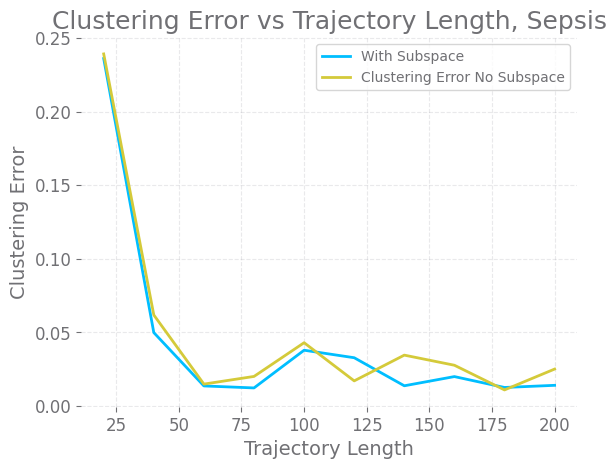

In [17]:
#plt.figure(figsize=(16,9))
plt.plot(horizons, 1-np.mean(np.array(clusterAccsTrials),0), label='With Subspace')
plt.plot(horizons, 1-np.mean(np.array(clusterAccsNoProjsTrials),0), label='Clustering Error No Subspace')
plt.ylabel("Clustering Error")
plt.xlabel("Trajectory Length")
plt.title("Clustering Error vs Trajectory Length, Sepsis")
plt.legend()
plt.savefig('figs/clustering.png')

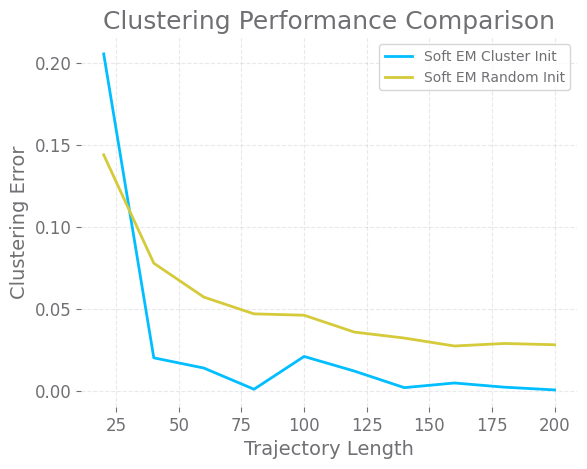

In [203]:
#plt.figure(figsize=(16,9))
'''
plt.plot(horizons, 1-np.median(np.array(hardClustEMAccsTrials),0),
         label='Hard EM Cluster Init')
plt.plot(horizons, 1-np.median(np.array(hardEMAccsTrials),0),
        label='Hard EM')
'''       
plt.plot(horizons, 1-np.mean(np.array(softClustEMAccsTrials),0),
         label='Soft EM Cluster Init')
plt.plot(horizons, 1-np.mean(np.array(softEMAccsTrials),0),
        label='Soft EM Random Init')
plt.ylabel("Clustering Error")
plt.xlabel("Trajectory Length")
plt.title("Clustering Performance Comparison")
plt.legend()
plt.savefig('figs/emcomp.png')

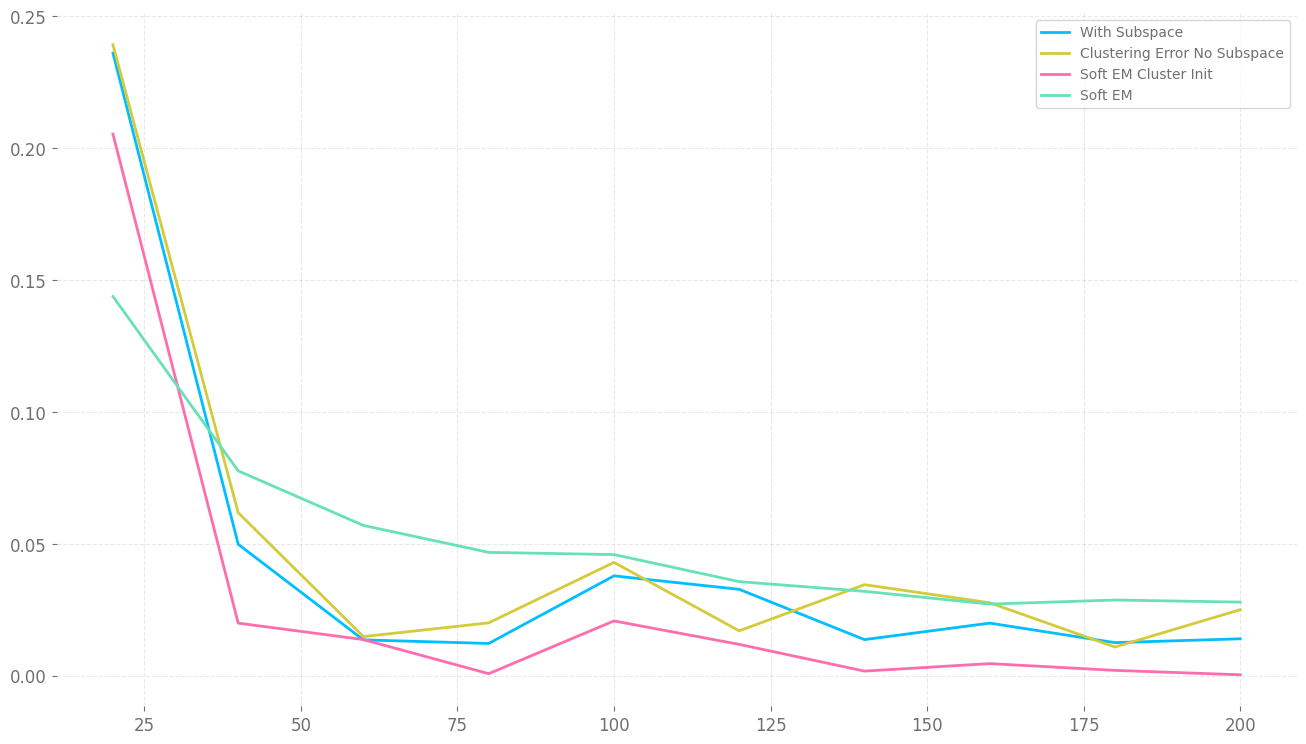

In [22]:
plt.figure(figsize=(16,9))
plt.plot(horizons, 1-np.mean(np.array(clusterAccsTrials),0), label='With Subspace')
plt.plot(horizons, 1-np.mean(np.array(clusterAccsNoProjsTrials),0), label='Clustering Error No Subspace')
'''
plt.plot(horizons, 1-np.array(classAccs), label='Subspace Classification')
plt.plot(horizons, 1-np.array([np.max([np.mean(i[0]==labels), 
                  np.mean(i[0]!=labels)]) for i in hardClustEMs]),
         label='Hard EM Cluster Init')
plt.plot(horizons, 1-np.array([np.mean([np.max([np.mean(j.argmax(0)==labels), np.mean(j.argmax(0)!=labels)]) 
  for j in hardEMs[i][0]]) for i in range(len(hardEMs))]),
        label='Hard EM')
'''
plt.plot(horizons, 1-np.mean(np.array(softClustEMAccsTrials),0),
         label='Soft EM Cluster Init')
plt.plot(horizons, 1-np.mean(np.array(softEMAccsTrials),0),
        label='Soft EM')
plt.legend()